In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import math
import json
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


def crime_clean_data(df):
    df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce')
    return df[(df['CMPLNT_FR_DT'] > '2017-01-01 00:00:00') & (df['CMPLNT_FR_DT'] < '2018-01-01 00:00:00') & ~df['CMPLNT_FR_DT'].isnull() & ~np.isnan(df.Latitude)]

def liquor_clean_data(df):
    df['License Effective Date'] = pd.to_datetime(df['License Effective Date'], errors='coerce')
    return df[(df['License Effective Date'] > '2017-01-01 00:00:00') & \
              (df['License Effective Date'] < '2018-01-01 00:00:00') & (~df['License Effective Date'].isnull()) & \
              (df['Agency Zone Office Name'] == 'New York City') & (~np.isnan(df.Latitude)) & \
              (df['License Type Name'].str.contains('ON-PREMISES LIQUOR'))]

def bounds_within_km(loc):
    dist = 1.6 # 1km
    radius = 6371 # Earth Radius in km
    lat = loc[0]
    lng = loc[1]
    max_lat = lat + np.rad2deg(dist/float(radius))
    min_lat = lat - np.rad2deg(dist/float(radius))
    max_lng = lng + np.rad2deg(dist/float(radius)/math.cos(np.deg2rad(lat)))
    min_lng = lng - np.rad2deg(dist/float(radius)/math.cos(np.deg2rad(lat)))
    
    return (min_lat, max_lat), (min_lng, max_lng)


def get_within_km(loc, df):
    lat_limits, lng_limits = bounds_within_km(loc)
    return df[(df['Latitude'] < lat_limits[1]) & (df['Latitude'] > lat_limits[0]) & \
              (df['Longitude'] < lng_limits[1]) & (df['Longitude'] > lng_limits[0])]

crime_df = pd.read_csv("complaint.csv",delimiter=',', low_memory=False)
crime_df= crime_clean_data(crime_df)
print crime_df.count()
liquor_df = pd.read_csv("liquor.csv",delimiter=',', low_memory=False)
liquor_df= liquor_clean_data(liquor_df)


CMPLNT_NUM           447372
CMPLNT_FR_DT         447372
CMPLNT_FR_TM         447372
CMPLNT_TO_DT         378030
CMPLNT_TO_TM         378226
RPT_DT               447372
KY_CD                447372
OFNS_DESC            447350
PD_CD                447106
PD_DESC              447106
CRM_ATPT_CPTD_CD     447372
LAW_CAT_CD           447372
JURIS_DESC           447372
BORO_NM              447372
ADDR_PCT_CD          447372
LOC_OF_OCCUR_DESC    359946
PREM_TYP_DESC        445655
PARKS_NM               3956
HADEVELOPT            23245
X_COORD_CD           447372
Y_COORD_CD           447372
Latitude             447372
Longitude            447372
Lat_Lon              447372
dtype: int64


In [2]:
same = 0
diff = 0
left_skew = 0
equal = 0
right_skew = 0

cum_prev_dist = []
cum_after_dist = []
Period = 60
with tqdm(total=len(list(liquor_df.iterrows()))) as pbar:
    for idx, row in liquor_df.iterrows():
        tup = eval(row['Location'])
        
        crime_loc_df = get_within_km(tup, crime_df)
        
        license_time = pd.to_datetime(row['License Effective Date'])
        prev = license_time.to_pydatetime() + timedelta(days=-Period)
        
        prev_dist = []
        after_dist = []
        
        for date in pd.date_range(prev, periods=Period):
            q_date = date.strftime("%m/%d/%Y")
            prev_dist.append(len(crime_loc_df[crime_loc_df['CMPLNT_FR_DT'] == q_date]))
        cum_prev_dist.append(prev_dist)
        
        for date in pd.date_range(license_time, periods=Period):
            q_date = date.strftime("%m/%d/%Y")
            after_dist.append(len(crime_loc_df[crime_loc_df['CMPLNT_FR_DT'] == q_date]))
            
        cum_after_dist.append(after_dist)
        # N = 60, statistic= 0.1753
        # N = 30, statistic= 0.24170
        if stats.ks_2samp(prev_dist, after_dist)[0] > 0.1753: # 95% CI, 30 days of samples. Reject Null Hypothesis (to be the same)
            prev_skew = sum(prev_dist)
            after_skew = sum(after_dist)      
            if after_skew > prev_skew:
                right_skew += 1
            elif after_skew < prev_skew:
                left_skew += 1
            else:
                equal += 1
            diff += 1
        else:
            same += 1
        pbar.update(1)

100%|██████████| 5113/5113 [10:20<00:00, 10.35it/s]


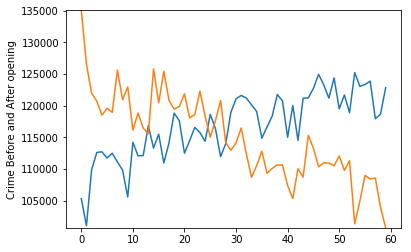

Number of Results with same distribution: 3347
Number of Results with hike: 1766
Crime remained same for diff distributions: 0
Crime decreased: 776
Crime increase: 990


In [3]:
cum_prev_dist = np.array(cum_prev_dist)
cum_prev_dist = np.array(cum_prev_dist).sum(axis=0)

plt.plot(cum_prev_dist)
plt.ylabel('Crime Before and After opening')
cum_after_dist = np.array(cum_after_dist)
cum_after_dist = np.array(cum_after_dist).sum(axis=0)
plt.ylim(min(np.amin(cum_after_dist), np.amin(cum_prev_dist)), max(np.amax(cum_after_dist), np.amax(cum_prev_dist)))

plt.plot(cum_after_dist)
plt.show()
print "Number of Results with same distribution: " + str(same)
print "Number of Results with hike: " + str(diff)

print "Crime remained same for diff distributions: " + str(equal)
print "Crime decreased: " + str(left_skew)
print "Crime increase: " + str(right_skew)
        